# Financial inclusion in Africa
In this notebook we develop a machine learning model to predict which individuals are most likely to have or use a bank account. The data come from a the zindi [Financial inclusion in Africa](https://zindi.africa/competitions/financial-inclusion-in-africa) competition.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

#### helper functions . 
moved to associated python file

In [2]:
def stacked_barplot(df, feature):

    df_grp = pd.DataFrame(df.groupby(feature)['bank_account'].value_counts().unstack().fillna(0)).reset_index()
    x = np.array(df_grp.household_size)
    no = np.array(df_grp.No)
    yes = np.array(df_grp.Yes)

    # normalization
    snum = no+yes
    no = no/snum*100.
    yes = yes/snum*100.

    # stack bars
    plt.figure(figsize=(15,6))
    plt.bar(x, no, label='No')
    plt.bar(x, yes, bottom=no,label='Yes')

    # add text annotation corresponding to the percentage of each data.
    for xpos, ypos, yval in zip(x, no/2, no):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")

    for xpos, ypos, yval in zip(x, no+yes/2, yes):
        plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")

    plt.ylim(0,105)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')

In [3]:
# load dataset
df = pd.read_csv('data/Train_v2.csv')

# rows and columns of the data
print(df.shape)

# visualise the dataset
df.head()

(23524, 13)


,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [4]:
df.columns

Index(['country', 'year', 'uniqueid', 'bank_account', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type'],
      dtype='object')

In [5]:
# add country to unique id
df['uniqueid'] = df['country'] + "_"+ df['uniqueid']

In [6]:
# check number of unique individuals in the dataset
print("Number of unique individuals in the dataset {}".format(len(df.uniqueid.unique())))

# check years
print("print the years in the dataset {}".format(df.year.unique()))

# number of countries
print("Number of countries in the dataset {}".format(df.country.unique()))

Number of unique individuals in the dataset 23524
print the years in the dataset [2018 2016 2017]
Number of countries in the dataset ['Kenya' 'Rwanda' 'Tanzania' 'Uganda']


In [7]:
no_dedup = df.drop(['bank_account','year'], axis=1).drop_duplicates().shape[0]
print("Number of non unique records {}".format(no_dedup))


Number of non unique records 23524


The Finacial inclusion data contains 23500 individuals (records) and 13 deographic variables.  
The data was collected over a 3 year period and each record represents a unique individual.


**We will analyse the dataset to identify:**

1. Missing values
2. Numerical variables
3. Distribution of the numerical variables
4. Outliers
5. Categorical variables
6. Cardinality of the categorical variables
7. Potential relationship between the variables and the target: SalePrice

In [8]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum()>1]

# print the variable name and the percentage of missing values
for var in vars_with_na:
    print(var, np.round(df[var].isnull().mean(), 3),  ' % missing values')

There are no missing values in the dataset.

### check distribution of our response variable

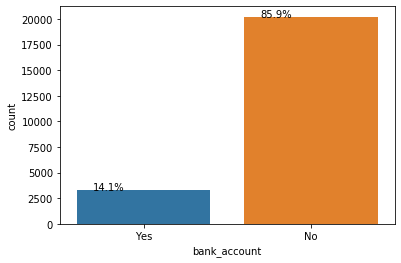

In [9]:
fig, ax = plt.subplots()
sns.countplot(x='bank_account',data=df)
n = df.shape[0]
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/n), (p.get_x()+0.1, p.get_height()))

From the distribution of the response variable we observe that we have an imbalanced dataset with 14% of our respondent having a bank account while 865 do not have one

### Numerical variables

Get all numerical variables in the dataset

In [10]:
# list of numerical variables
num_vars = [var for var in df.columns if df[var].dtypes != 'O']

print('Number of numerical variables: ', len(num_vars))

# visualise the numerical variables
df[num_vars].head()

Number of numerical variables:  3


,year,household_size,age_of_respondent
0,2018,3,24
1,2018,5,70
2,2018,5,26
3,2018,5,34
4,2018,8,26


In [11]:
# print number of unique values in the numerical variables
for var in num_vars:
    print("{}: {}".format(var, len(df[var].unique())))

year: 3
household_size: 20
age_of_respondent: 85


We have 3 numeric variables in the dataset.  
- year: with 3 values (we will analysis this as a categorical variable to evaluate if it has imact on the response)
- household size: with 20 distinct values (possible variable to regrouped into fewer categories)
- age_of_respondent: 85 unique values and also candidate for regrouping

#### Household size

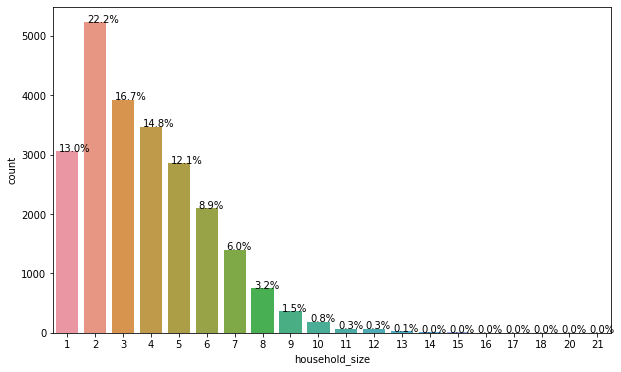

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='household_size', data=df)
n = df.shape[0]
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/n), (p.get_x()+0.1, p.get_height()))

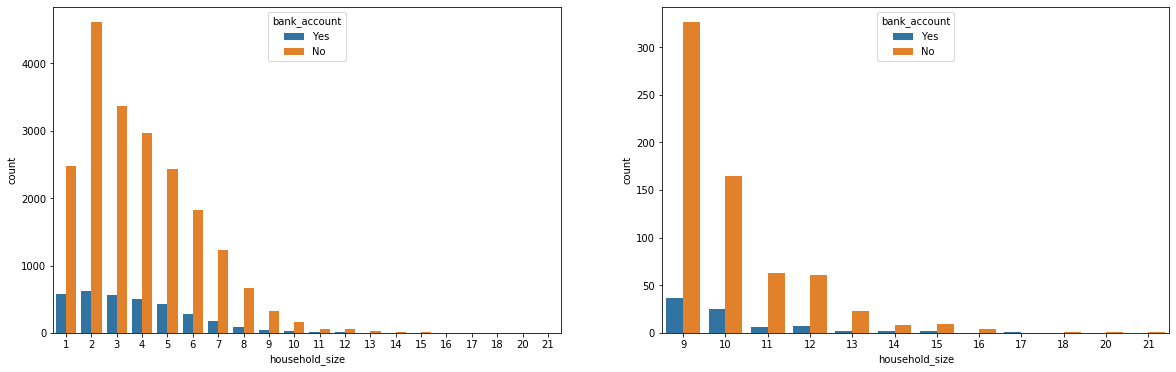

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.countplot(x='household_size', hue='bank_account', data=df, ax=ax1, hue_order=['Yes', 'No'])
sns.countplot(x='household_size', hue='bank_account', data=df[df.household_size > 8], ax=ax2, hue_order=['Yes', 'No'])

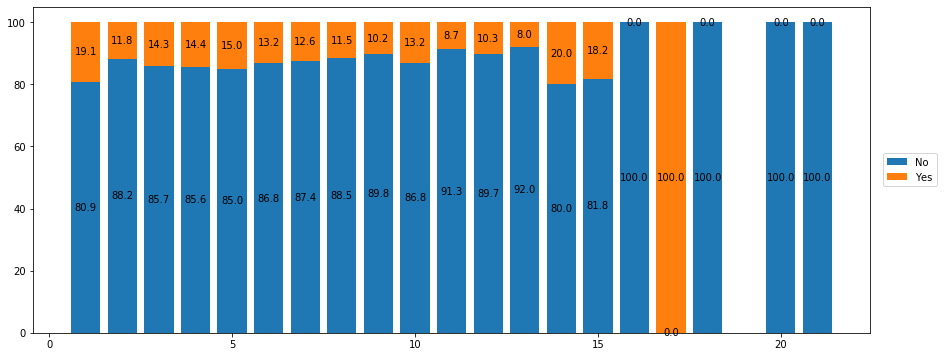

In [14]:
feature = 'household_size'
stacked_barplot(df, feature)

The distribution of the number of house in the dataset is skewed to the left with most of the household size in the interval 1 - 8.  
The stacked barplot shows that those having bank accounts are over represented in singles (19%) and household size of 14 and 15. While taking into account thr top barplot it is likely that the over representation in this houshold size is most likelya bias due to data collection as there are only about 50 persons in that group.
While a fairly similar representation can be found for household of size between 2 - 10 . 


In [15]:
bins=[0, 1, 5, 6, 200]
df['household_size_bins'] = pd.cut(x=df['household_size'], bins=bins)
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,household_size_bins
0,Kenya,2018,Kenya_uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,"(1, 5]"
1,Kenya,2018,Kenya_uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,"(1, 5]"
2,Kenya,2018,Kenya_uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,"(1, 5]"
3,Kenya,2018,Kenya_uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,"(1, 5]"
4,Kenya,2018,Kenya_uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,"(6, 200]"


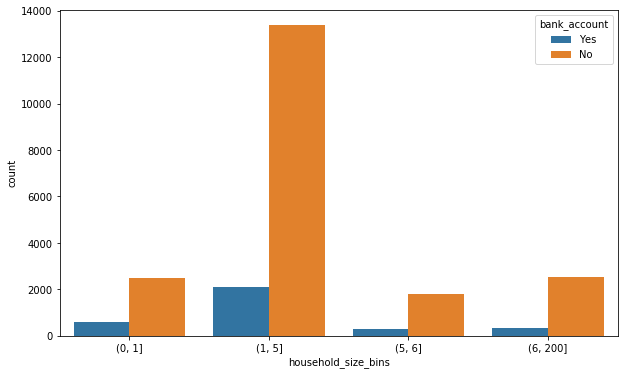

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x='household_size_bins', hue='bank_account', data=df, hue_order=['Yes', 'No'])

#### Age 

In [17]:
def age_distribution(data, var, label):
    data = data.copy()
    #fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(data[data.bank_account == 'Yes'][var], hist=False, label='Yes')
    sns.distplot(data[data.bank_account == 'No'][var], hist=False, label='No')

    plt.title('Age distribution per class ' + label)
    plt.xlabel('Age of respondent')
    plt.ylabel('Density')
    
    plt.show()
    

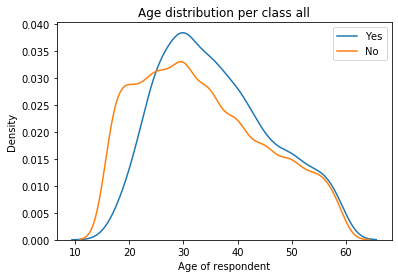

In [18]:
var = 'age_of_respondent'
age_distribution(df[df.age_of_respondent < 60], var, 'all')

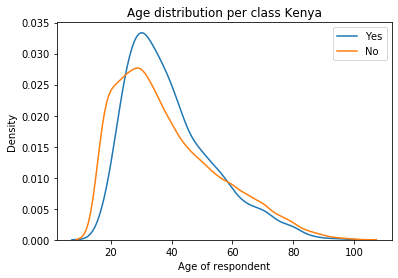

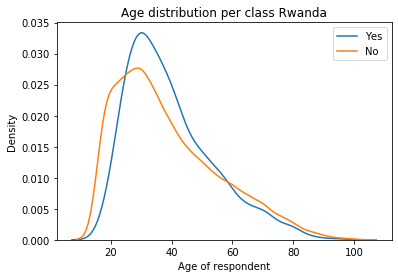

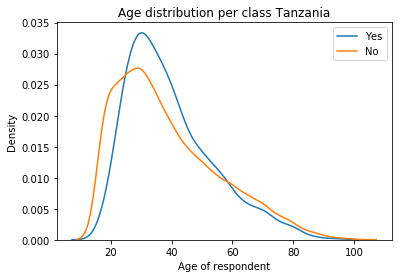

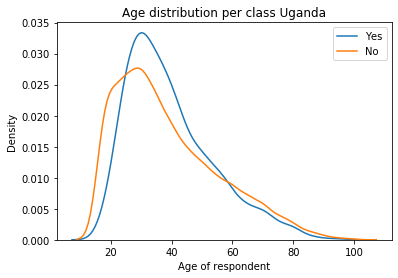

In [37]:
var = 'age_of_respondent'
for country in df.country.unique():
    #print(country)
    # df_tmp = df[(df.country == country) & (df.age_of_respondent < 60)]
    age_distribution(df, var, country)

In [20]:
from scipy.stats import mannwhitneyu

# compare samples
values_yes = df[df.bank_account == 'Yes'][var].values
values_no = df[df.bank_account == 'No'][var].values

stat, p = mannwhitneyu(values_yes, values_no)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=30957246.000, p=0.000
Different distribution (reject H0)


Age distribution does not show a clear difference between individauls with and without bank accounts. 
Age distribution is similar acros all the countries.

In [21]:
bins=[0,24, 34, 44, 54, 64, 74, 200]
df['age_bins'] = pd.cut(x=df['age_of_respondent'], bins=bins)
df.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,household_size_bins,age_bins
0,Kenya,2018,Kenya_uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed,"(1, 5]","(0, 24]"
1,Kenya,2018,Kenya_uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent,"(1, 5]","(64, 74]"
2,Kenya,2018,Kenya_uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed,"(1, 5]","(24, 34]"
3,Kenya,2018,Kenya_uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private,"(1, 5]","(24, 34]"
4,Kenya,2018,Kenya_uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed,"(6, 200]","(24, 34]"


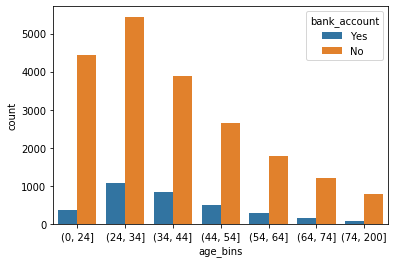

In [22]:
sns.countplot(x='age_bins', hue='bank_account', data=df, hue_order=['Yes', 'No'])

### Categorical variales

In [23]:
categorical_var = [var for var in df.columns if df[var].dtype == 'O' and var not in  ['bank_account', 'uniqueid']]
len(categorical_var)

8

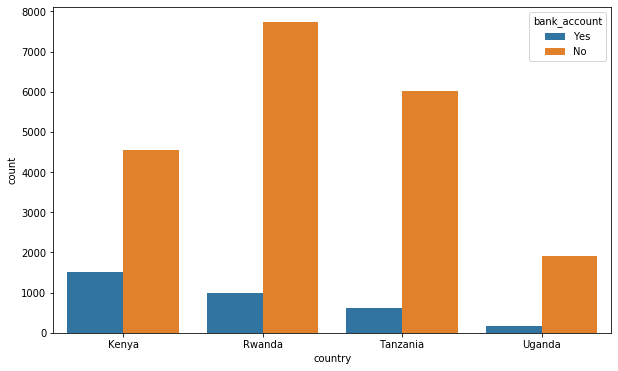

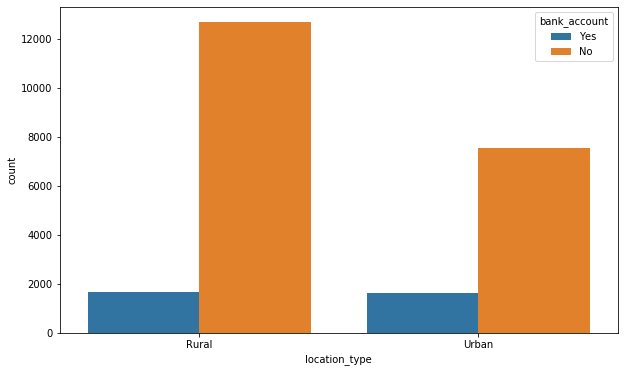

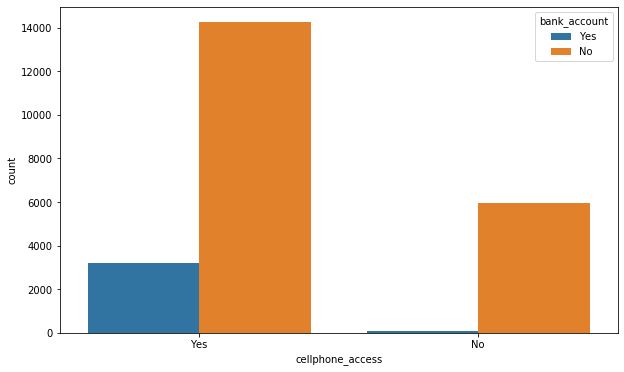

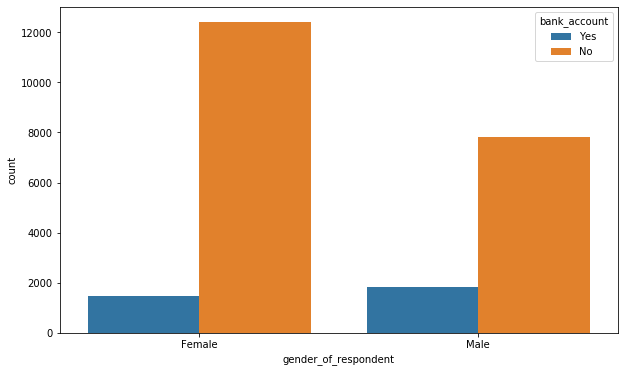

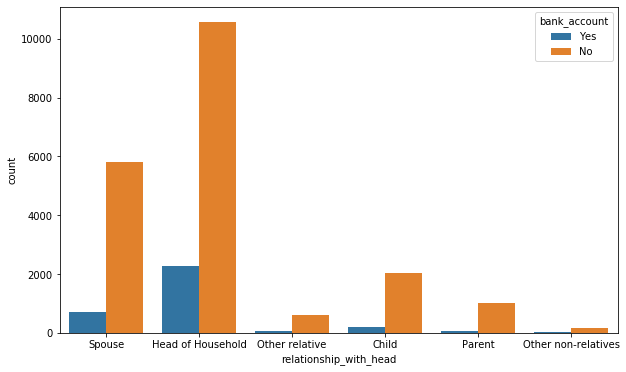

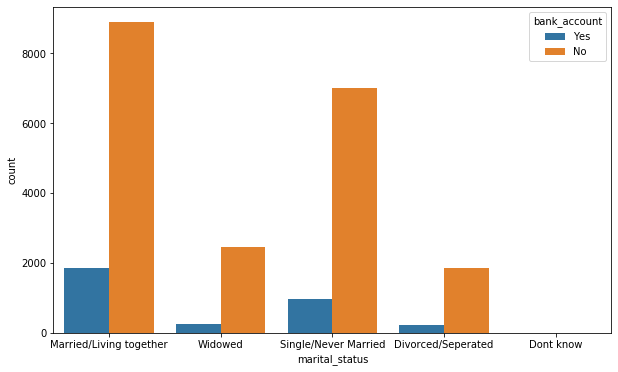

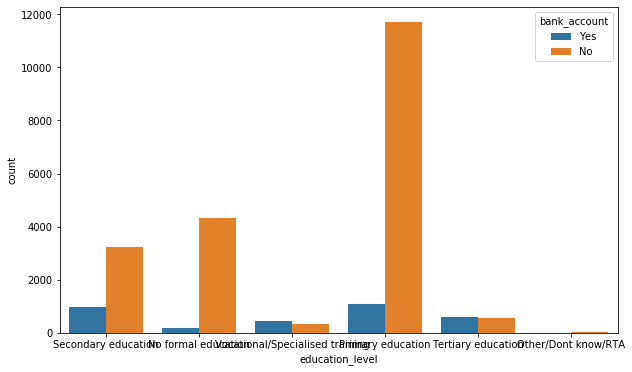

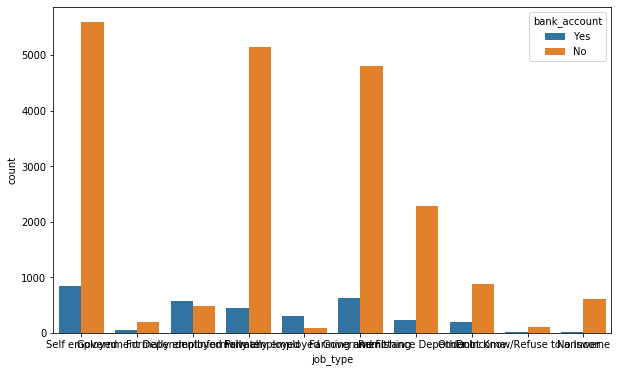

In [24]:
for i, var in enumerate(categorical_var):
    plt.subplots(figsize=(10, 6))
    ax = sns.countplot(x=var, hue='bank_account', data=df, hue_order=['Yes', 'No'])
    plt.show()

#### household size by marital status

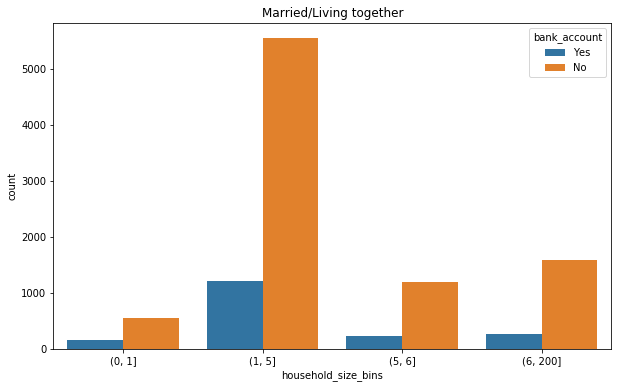

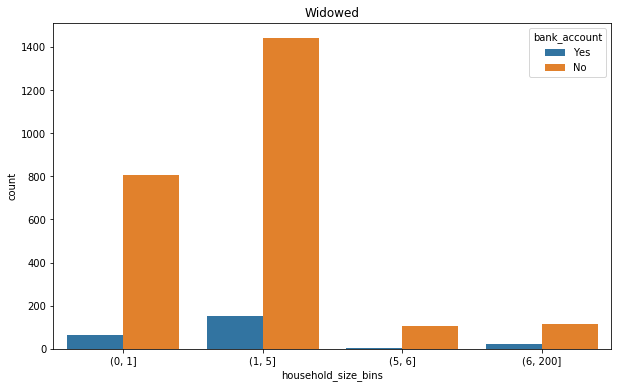

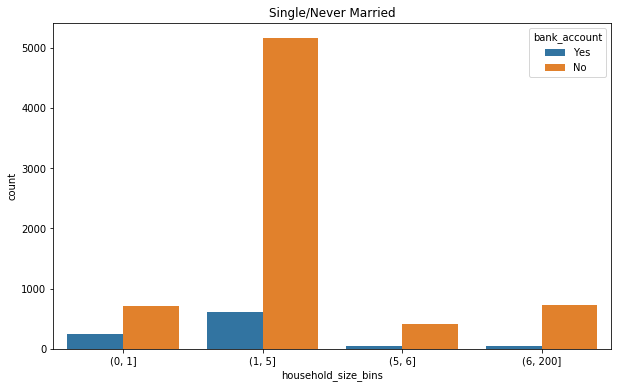

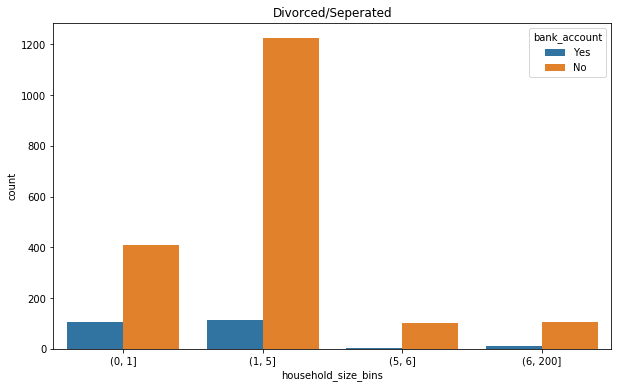

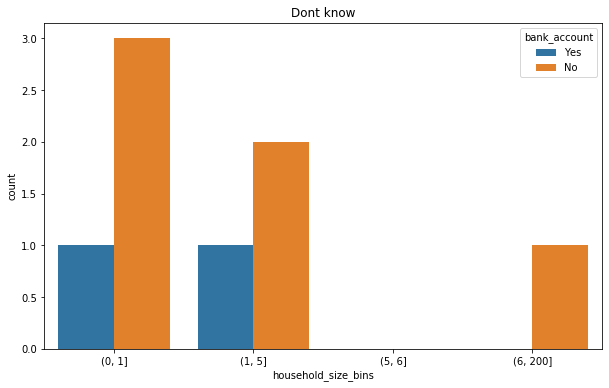

In [25]:
for modality in df.marital_status.unique():
    plt.subplots(figsize=(10, 6))
    df_tmp = df[df.marital_status == modality]
    sns.countplot(x='household_size_bins', hue='bank_account', data=df_tmp, hue_order=['Yes', 'No'])
    plt.title(modality)
    plt.show()

We can see from the bar plot above that there is a fairly similar distribution of the household size for the different modalities in the marital status except for the Don't Know group and this is likel due to the sample size in the data.  
We can assume there is no interaction effect between marital status and house (NB: confirmation with a formal statistical test)

#### household size by location_type

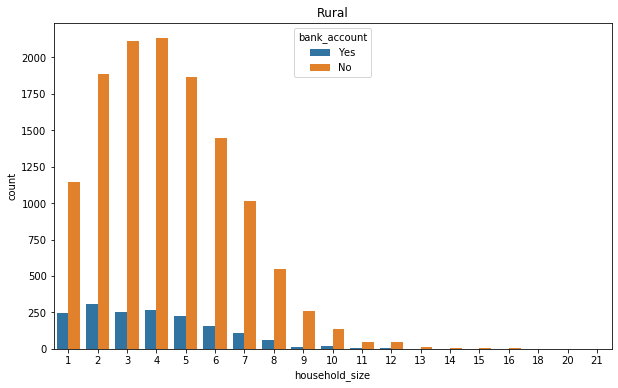

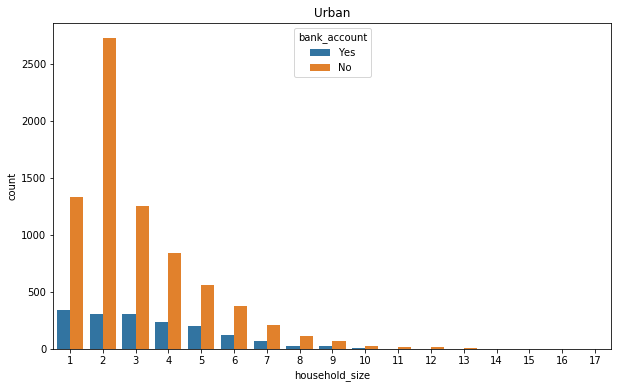

In [26]:
for modality in df.location_type.unique():
    plt.subplots(figsize=(10, 6))
    df_tmp = df[df.location_type == modality]
    sns.countplot(x='household_size', hue='bank_account', data=df_tmp, hue_order=['Yes', 'No'])
    plt.title(modality)
    plt.show()

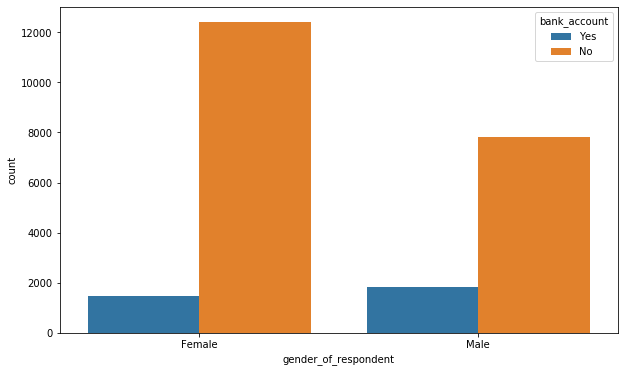

In [27]:
plt.subplots(figsize=(10, 6))
sns.countplot(x='gender_of_respondent', hue='bank_account', data=df, hue_order=['Yes', 'No'])

In [28]:
from helper.categorical_encoder import CategoricalEncoder
from sklearn.model_selection import train_test_split

df['target'] = df['bank_account'].apply(lambda x: 1 if x == 'Yes' else 0)

#df['year'] = df['year'].astype('str')
#df['age_bins'] = df['age_bins'].astype('str')
#df['household_size_bins'] = df['household_size_bins'].astype('str')

features = ['target', 'country', 'year', 'location_type', 'cellphone_access','gender_of_respondent','relationship_with_head', 'marital_status','education_level', 'job_type', 'age_bins', 'household_size_bins']

df_train, df_test = train_test_split(df[features], test_size=0.1, random_state=4)

In [29]:
target = 'target'
ce = CategoricalEncoder(df_train, target)
ce.categorical_encoding_rtt()

There are 3 binary variables
There are 5 categorical variables
There are 3 discrete variables
There are 0 continuous variables
There are 8 combined discrete + categorical variables


In [30]:
ce.df_encoded.head()

,target,country,year,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_bins,household_size_bins
48,0,0.363454,0.298669,1,1,0,0.126053,0.239367,0.809839,0.205919,0.240623,0.194283
18769,1,0.128767,0.128767,0,1,0,0.159743,0.155007,0.809839,0.796141,0.240623,0.194283
4471,0,0.363454,0.298669,0,1,0,0.246895,0.137340,0.053058,0.099347,0.175328,0.194283
6429,0,0.153704,0.153704,0,1,0,0.156679,0.239367,0.116725,0.099347,0.264927,0.187199
9211,0,0.153704,0.153704,0,0,1,0.246895,0.239367,0.053058,0.099347,0.240623,0.194283


In [31]:
def plot_encoding(var):
    plt.subplots(figsize=(10, 6))
    x_axis = list(ce.modality_count_dict[var].keys())
    y_axis = [ce.modality_count_dict[var][modality] for modality in x_axis]
    y_axis_index = [ce.encoding_dict_average[var][modality] for modality in x_axis]

    ax = sns.barplot(x=x_axis, y=y_axis)
    ax.set_title(var)
    ax.set_xticklabels(labels=x_axis, rotation=30, ha="right")
    ax2 = ax.twinx()
    ax2.plot(ax.get_xticks(), y_axis_index, lw=2, color='black')
    plt.show()

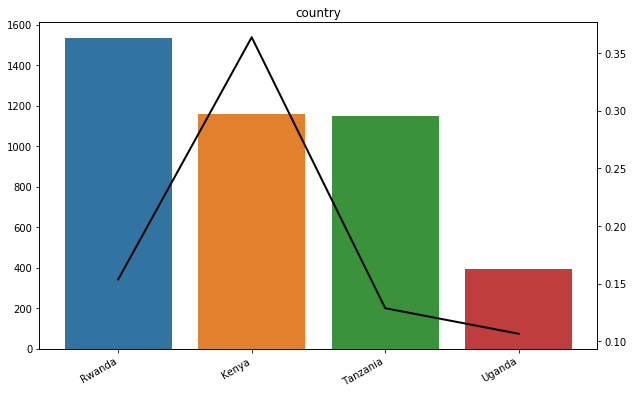

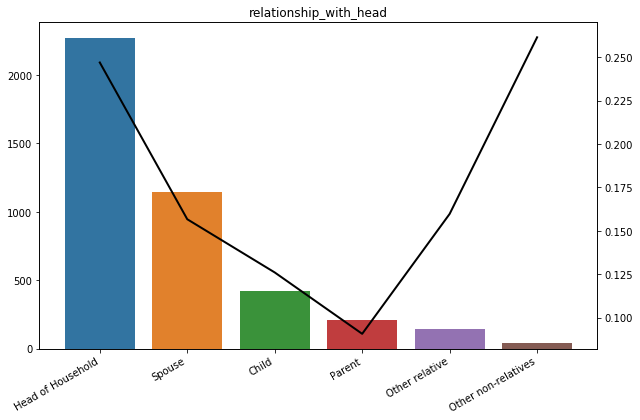

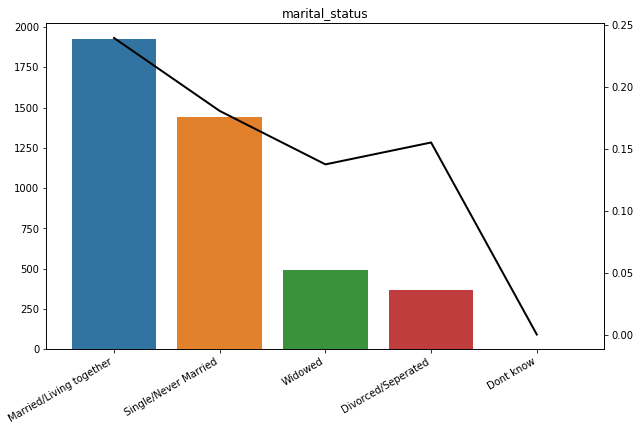

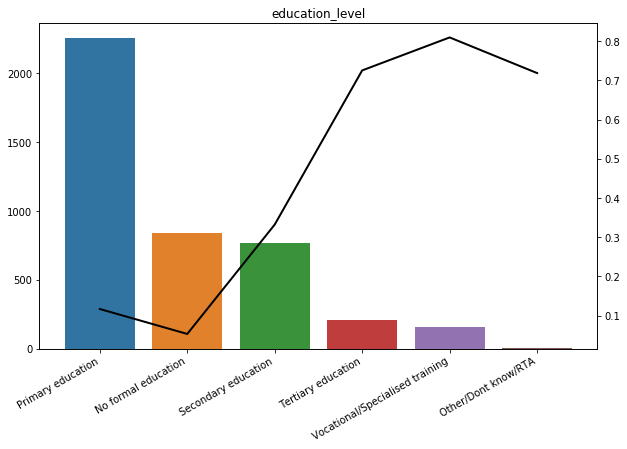

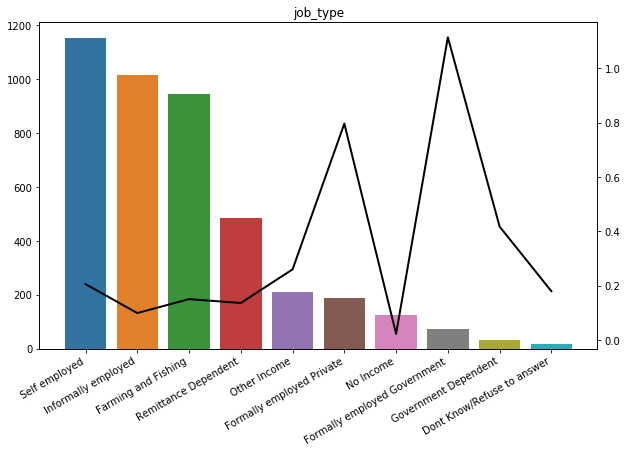

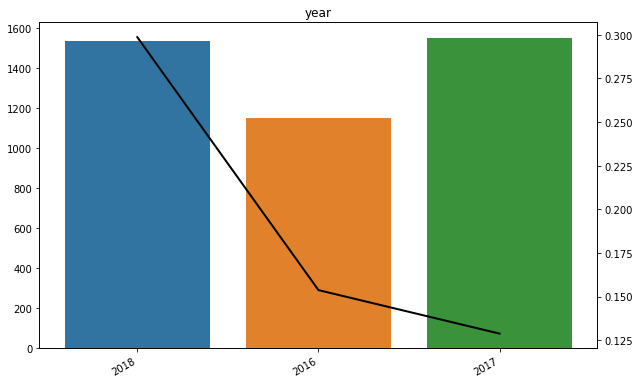

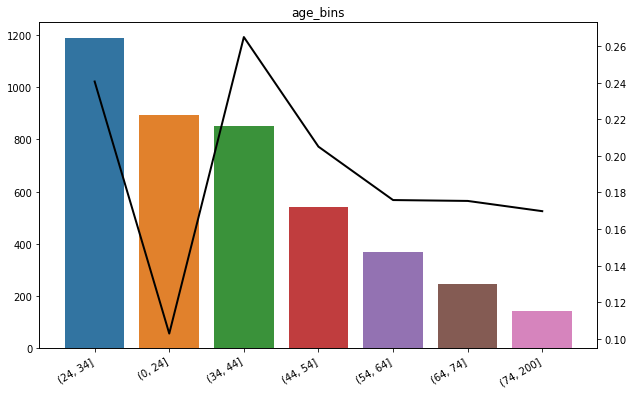

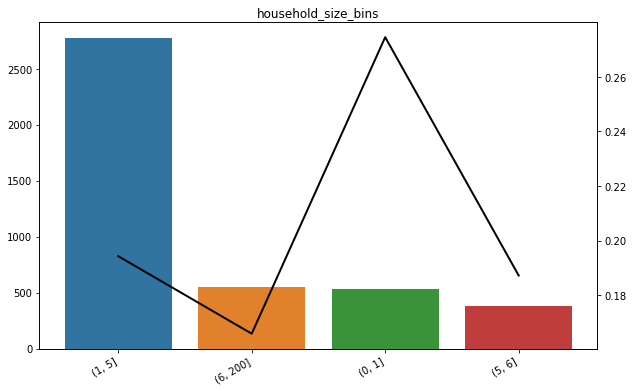

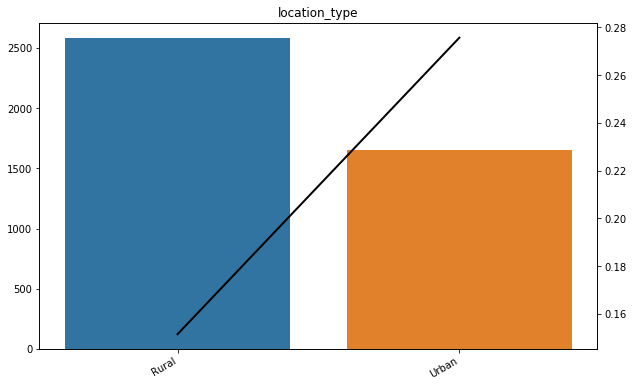

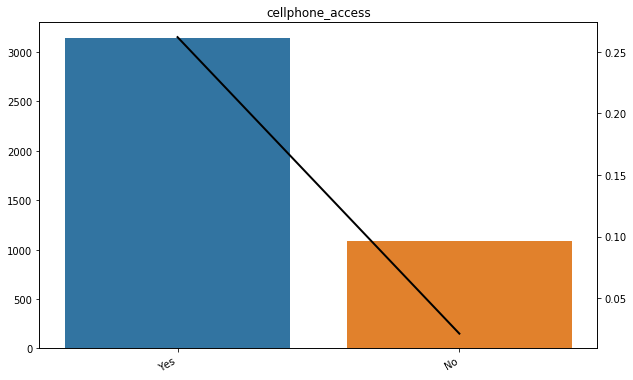

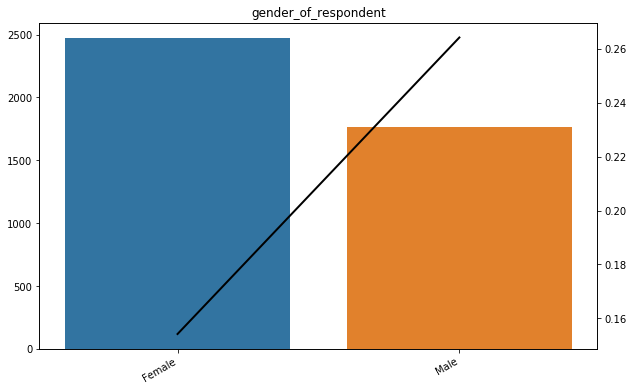

In [32]:
for var in ce.encoding_dict_average:
    plot_encoding(var)

### Feature selection with Lasso

In [33]:
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [34]:
X = ce.df_encoded.drop(['target'], axis=1)
y = ce.df_encoded['target']

In [35]:
lr_sel = SelectFromModel(LogisticRegression(C=0.01, penalty='l1',solver='liblinear'))
lr_sel.fit(X, y)

# list of selected features
selected_feat = list(X.columns[(lr_sel.get_support())])
print('total features: {}'.format((X.shape[1])))
print('number of selected features: {}'.format(len(selected_feat)))
print('List of selected features: {}'.format(selected_feat))
print('features with coefficients shrank to zero: {}'.format(np.sum(lr_sel.estimator_.coef_ == 0)))

total features: 11
number of selected features: 5
List of selected features: ['location_type', 'cellphone_access', 'gender_of_respondent', 'education_level', 'job_type']
features with coefficients shrank to zero: 6


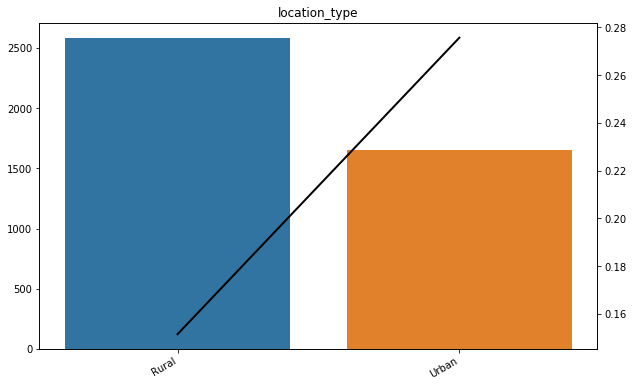

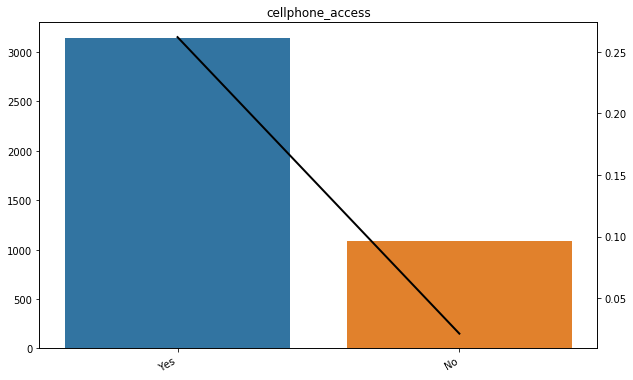

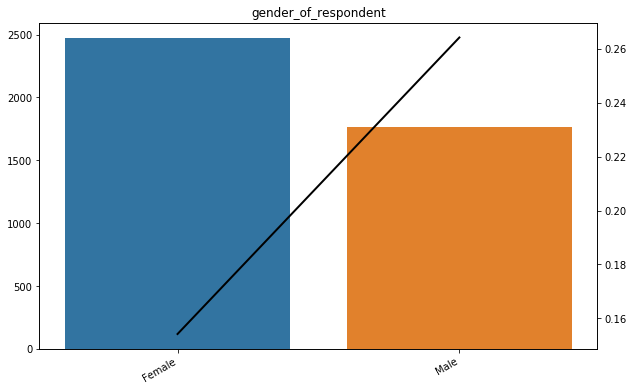

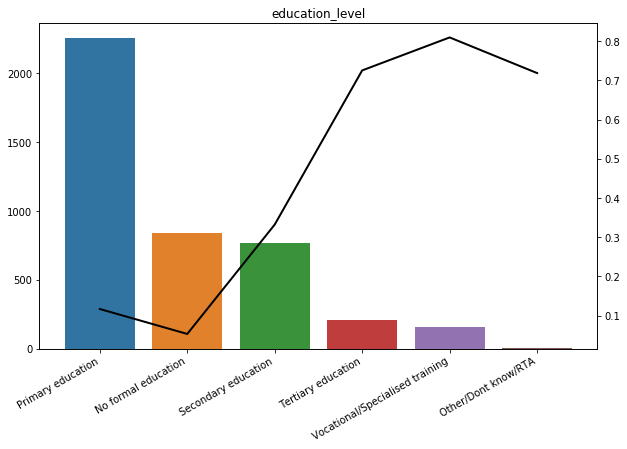

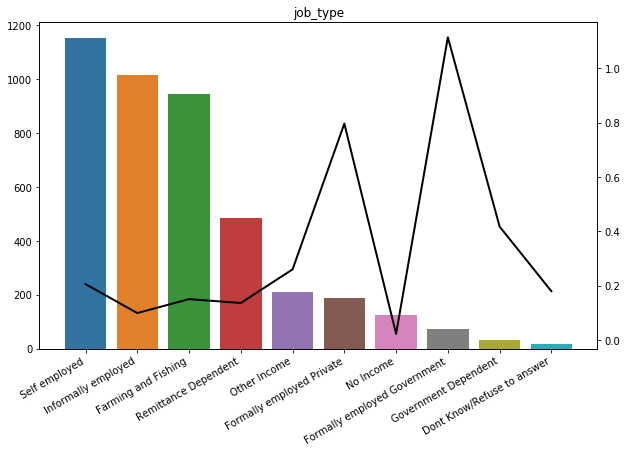

In [36]:
# for var in selected_feat:
#     plot_encoding(var)